In [25]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity


In [26]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./tmp/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./tmp/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, conv_config, pool_type, dropout_rate, flip_kernel, sparsity=0.0,
                 use_tiled=False, use_unshared=False, use_locally_connected=False, padding_style='same'):
        super(CustomCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.flip_kernel = flip_kernel
        self.sparsity = sparsity
        self.use_tiled = use_tiled
        self.use_unshared = use_unshared
        self.use_locally_connected = use_locally_connected
        self.padding_style = padding_style

        input_channels = 3
        for out_channels, kernel_size, stride, padding in conv_config:
            if self.use_tiled:
                self.layers.append(self.create_tiled_conv(input_channels, out_channels, kernel_size, stride, padding))
            elif self.use_unshared:
                self.layers.append(self.create_unshared_conv(input_channels, out_channels, kernel_size))
            elif self.use_locally_connected:
                self.layers.append(self.create_locally_connected(input_channels, out_channels, kernel_size, stride, padding))
            else:
                self.layers.append(nn.Conv2d(input_channels, out_channels, kernel_size, stride, 0))  # No padding initially
            input_channels = out_channels

        self.pool_type = pool_type
        flattened_size = self.get_flattened_size((3, 32, 32))  # CIFAR-10 input shape
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def compute_padding(self, kernel_size, stride, input_size, padding_style):
        if padding_style == 'valid':
            return 0
        elif padding_style == 'same':
            return ((input_size - 1) * stride + kernel_size - input_size) // 2
        elif padding_style == 'full':
            return kernel_size - 1
        else:
            raise ValueError(f"Unknown padding style: {padding_style}")

    def create_tiled_conv(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom tiled convolution implementation
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)  # Placeholder

    def create_unshared_conv(self, in_channels, out_channels, kernel_size):
        # Custom unshared convolution using nn.Unfold and nn.Linear
        return nn.Sequential(
            nn.Unfold(kernel_size),
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
        )

    def create_locally_connected(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom locally connected layer implementation
        height, width = 32, 32  # Input image dimensions
        output_height = (height + 2 * padding - kernel_size) // stride + 1
        output_width = (width + 2 * padding - kernel_size) // stride + 1
        return nn.ModuleList([
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
            for _ in range(output_height * output_width)
        ])

    def get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        with torch.no_grad():
            for conv in self.layers:
                x = F.relu(self.custom_conv(conv, x))
                x = self.pool_type(x)
        return x.numel()

    def custom_conv(self, conv, x):
        if isinstance(conv, nn.ModuleList):  # Locally connected layer
            output = []
            patches = F.unfold(x, kernel_size=3, stride=1).transpose(1, 2)  # Example kernel size and stride
            for i, layer in enumerate(conv):
                output.append(layer(patches[:, i]))
            return torch.stack(output, dim=1).view(x.size(0), -1, x.size(2) - 2, x.size(3) - 2)
        elif isinstance(conv, nn.Sequential):  # Unshared convolution
            return conv(x)
        else:  # Regular convolution
            kernel_size = conv.kernel_size[0]
            stride = conv.stride[0]
            input_size = x.shape[-1]
            padding = self.compute_padding(kernel_size, stride, input_size, self.padding_style)

            if self.flip_kernel:
                # Default PyTorch behavior with kernel flipping
                return F.conv2d(x, conv.weight, bias=conv.bias, stride=conv.stride, padding=padding)
            else:
                # Custom implementation without kernel flipping
                weight = conv.weight
                flipped_weight = torch.flip(weight, dims=[2, 3])  # Flip the kernel
                return F.conv2d(x, flipped_weight, bias=conv.bias, stride=conv.stride, padding=padding)

    def apply_sparsity(self, weight):
        if self.sparsity > 0.0:
            mask = torch.rand_like(weight) > self.sparsity
            weight = weight * mask.float()  # Apply the sparsity mask
        return weight

    def forward(self, x):
        for conv in self.layers:
            # Apply sparsity to weights
            if hasattr(conv, 'weight'):
                conv.weight.data = self.apply_sparsity(conv.weight.data)
            x = F.relu(self.custom_conv(conv, x))
            x = self.pool_type(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [28]:
# Function to Calculate Model Parameters and FLOPs
def calculate_params_and_flops(model, input_shape):
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Count FLOPs
    dummy_input = torch.zeros(1, *input_shape)
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(dummy_input)
    
    flops = sum([event.count for event in prof.key_averages()])
    return total_params, flops


In [30]:
# Training and Evaluation Function
def train_and_evaluate(conv_config, pool_type, dropout_rate, flip_kernel, sparsity, 
                        use_tiled, use_unshared, use_locally_connected, padding_style,
                        train_loader, test_loader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model with all the additional parameters
    model = CustomCNN(
        conv_config, 
        pool_type, 
        dropout_rate, 
        flip_kernel, 
        sparsity, 
        use_tiled, 
        use_unshared, 
        use_locally_connected, 
        padding_style
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Calculate Parameters and FLOPs
    total_params, flops = calculate_params_and_flops(model, (3, 32, 32))  # CIFAR-10 input shape
    print(f"Total Parameters: {total_params}, FLOPs: {flops}")

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass (includes edge detection and convolution)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Evaluation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass (includes edge detection and convolution)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Return accuracy, parameters, and FLOPs
    return accuracy, total_params, flops


In [ ]:
# Experiment Settings
settings = [
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
   
]

# Run Experiments and Store Results
results = []
for i, setting in enumerate(settings):
    print(f"Running Experiment {i+1}/{len(settings)}...")

    # Unpack the dictionary 'setting' and pass additional required arguments explicitly
    accuracy, total_params, flops = train_and_evaluate(
        conv_config=setting["conv_config"],
        pool_type=setting["pool_type"],
        dropout_rate=setting["dropout_rate"],
        flip_kernel=setting["flip_kernel"],
        sparsity=setting["sparsity"],
        use_tiled=setting["use_tiled"],
        use_unshared=setting["use_unshared"],
        use_locally_connected=setting["use_locally_connected"],
        padding_style=setting["padding_style"],
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=3
)


    # Store the results
    results.append((f"Setting {i+1}", accuracy, total_params, flops))


Running Experiment 1/1...
Total Parameters: 1654722, FLOPs: 87


STAGE:2025-01-09 17:11:45 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-09 17:11:45 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-09 17:11:45 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.533725074794896
Epoch 2/3, Loss: 1.2340451411121642
Epoch 3/3, Loss: 1.0916761528043186
Test Accuracy: 63.47%


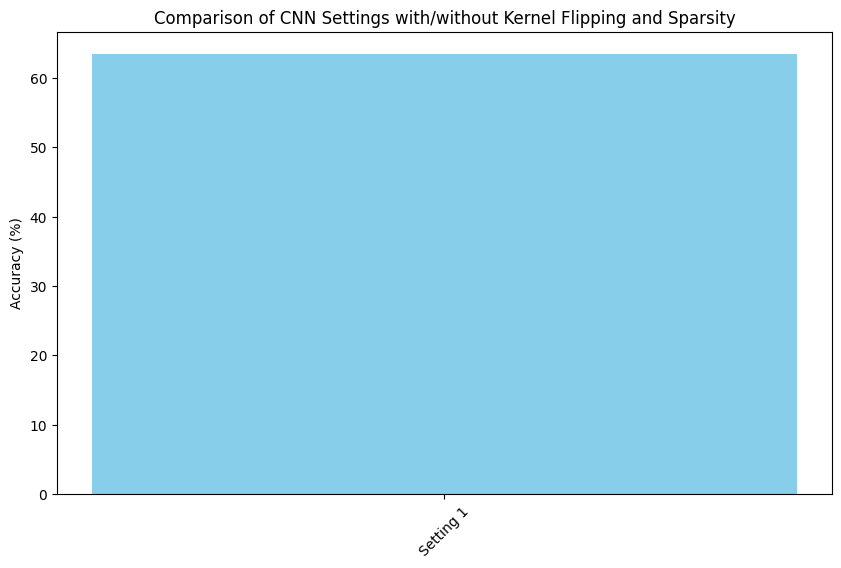

Setting 1: Accuracy = 63.47%, Params = 1654722, FLOPs = 87
Visualizing predictions for Setting 1...


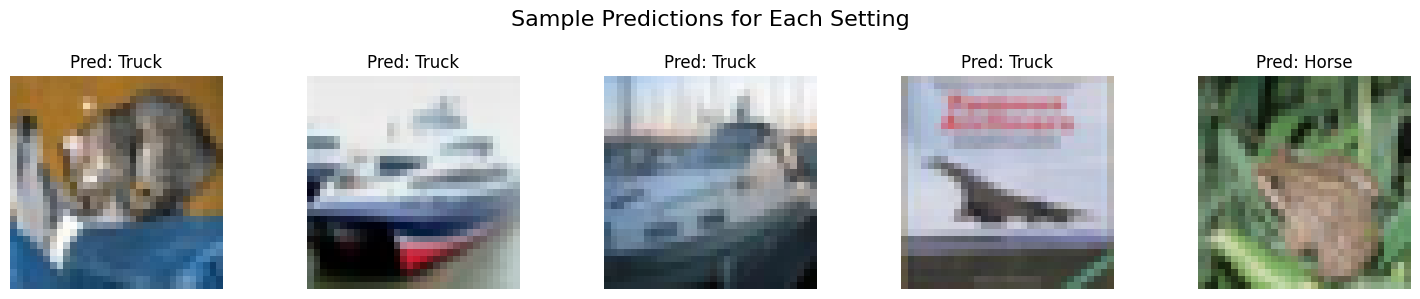

In [32]:
def visualize_results(settings, results, test_loader):
    label_mapping = {
        0:"Airoplane",
        1:"Automobile",
        2:"Bird",
        3:"Cat",
        4:"Deer",
        5:"Dog",
        6:"Frog",
        7:"Horse",
        8:"Ship",
        9:"Truck"
    }
    # Plot Accuracy Results
    labels, accuracies, params, flops = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies, color='skyblue')
    plt.ylabel("Accuracy (%)")
    plt.title("Comparison of CNN Settings with/without Kernel Flipping and Sparsity")
    plt.xticks(rotation=45)
    plt.show()

    # Display Computational Cost Results
    for i, (label, accuracy, param, flop) in enumerate(results):
        print(f"Setting {i+1}: Accuracy = {accuracy:.2f}%, Params = {param}, FLOPs = {flop}")

    # Display Predictions for Each Setting
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Adjust the number of subplots based on settings
    fig, axs = plt.subplots(len(settings), 5, figsize=(15, len(settings) * 3))
    fig.suptitle("Sample Predictions for Each Setting", fontsize=16)

    if len(settings) == 1:  # If only one setting, axs is a 1D array
        axs = axs.reshape(1, 5)  # Reshape to handle as 2D for consistency

    for i, setting in enumerate(settings):
        print(f"Visualizing predictions for Setting {i+1}...")
        # Load Model
        model = CustomCNN(**setting).to(device)
        model.eval()

        # Get 5 Sample Images and Predictions
        samples, predictions = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                samples.extend(inputs[:5].cpu())
                predictions.extend(predicted[:5].cpu())
                break  # Use only the first batch for visualization

        # Plot the Predictions
        for j in range(5):
            axs[i, j].imshow(transforms.ToPILImage()(samples[j] * 0.5 + 0.5))
            axs[i, j].set_title(f"Pred: {label_mapping[predictions[j].item()]}")
            axs[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run Experiments and Visualize
visualize_results(settings, results, test_loader)


In [33]:
def generate_gradcam(model, input_image, target_class=None):
    # Ensure the model is in evaluation mode
    model.eval()

    # Enable gradients for the input image
    input_image.requires_grad_()

    # Forward pass
    output = model(input_image)

    # If a specific class is not provided, use the predicted class
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass to get gradients for the target class
    model.zero_grad()
    output[0, target_class].backward()

    # Get gradients of the target class with respect to the feature maps
    gradients = input_image.grad

    # Get the activation of the last convolutional layer
    final_conv = model.layer4[2].conv3  # Adjust this based on your model's architecture
    activations = final_conv(input_image)

    # Global Average Pooling over activations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the activations by the pooled gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Sum the weighted activations across all channels
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Normalize the heatmap
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)

    # Convert to numpy for visualization
    heatmap = heatmap.cpu().detach().numpy()

    return heatmap

/var/folders/2c/lq_x3ldd70x6rjfy37hff1bh0000gp/T/ipykernel_72584/2718409725.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

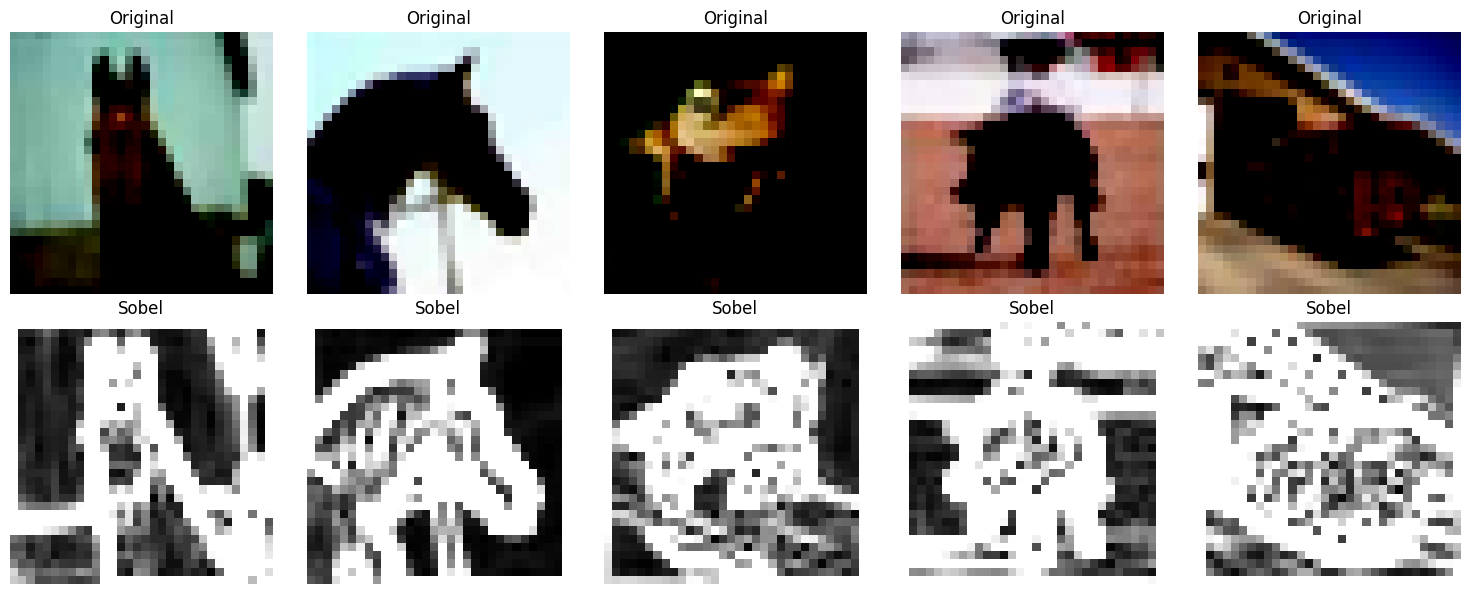

In [207]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to apply Sobel filter
def apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y):
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    if image.shape[1] == 3:  # Convert RGB to grayscale
        image = image.mean(dim=1, keepdim=True)
    sobel_x = F.conv2d(image, sobel_kernel_x, padding=1)
    sobel_y = F.conv2d(image, sobel_kernel_y, padding=1)
    sobel = torch.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return sobel.squeeze(0)  # Remove batch dimension

# Function to plot images
def plot_images(images, titles, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select some random images from the test dataset
random_indices = np.random.choice(len(test_dataset), 5, replace=False)
images = [test_dataset[i][0] for i in random_indices]

# Apply Sobel filter to the selected images
sobel_images = [apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y) for image in images]

# Plot the original and Sobel filtered images
plot_images(images + sobel_images, ['Original'] * 5 + ['Sobel'] * 5, rows=2, cols=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


RuntimeError: Given groups=1, weight of size [3, 1, 3, 3], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead

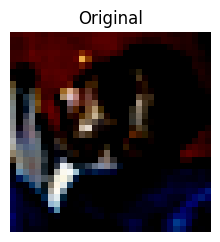

In [179]:
# Get some sample images from the test dataset
test_images = []
for i in range(5):  # Get 5 sample images
    image, _ = test_dataset[i]
    test_images.append(image)

# Create a function to apply Sobel edge detection and visualize results
def visualize_edge_detection(images):
    plt.figure(figsize=(15, 6))
    
    for i, img in enumerate(images):
        # Original image
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title('Original')
        plt.axis('off')
        
        # Apply Sobel edge detection
        # Use the pre-defined sobel kernels
        img = img.unsqueeze(0)  # Add batch dimension
        sobel_x = F.conv2d(img, sobel_kernel_x, padding=1)
        sobel_y = F.conv2d(img, sobel_kernel_y, padding=1)
        edge_magnitude = torch.sqrt(sobel_x ** 2 + sobel_y ** 2)
        
        # Show edge detection result
        plt.subplot(2, 5, i + 6)
        plt.imshow(edge_magnitude[0].mean(dim=0).detach(), cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_edge_detection(test_images)

In [6]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Hello"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
inputs = processor(
    text=[text],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cpu")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.


KeyboardInterrupt: 

In [226]:
%pip install qwen-vl-utils



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.4 MB 3.0 MB/s eta 0:00:01    |███████▎                        | 5.6 MB 2.2 MB/s eta 0:00:09
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
